In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import RMSprop
from os import path, makedirs
from keras.models import load_model

In [2]:
from segmentation_generators import InriaGenerator
from tiramisu import tiramisu

/home/ishivvers/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ishivvers/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Data Generators

These data generators assume the default format of the unzipped Inria data:
```
Inria/train/images/*.tif
           /gt/*.tif
     /val/images/*.tif
         /gt/*.tif
     /test/images/*.tif
```

In [3]:
tile_size = (512, 512)

traingen = InriaGenerator('/path/to/Inria/train/', tile_size=tile_size)
valgen = InriaGenerator('/path/to/Inria/val/', tile_size=tile_size)

### have a look

In [4]:
randgen = traingen.random_generator(1)

In [5]:
my_cmap = plt.cm.Blues(np.arange(plt.cm.Blues.N))
my_cmap[:250, -1] = 0
my_cmap[250:, -1] = 1
my_cmap = ListedColormap(my_cmap)

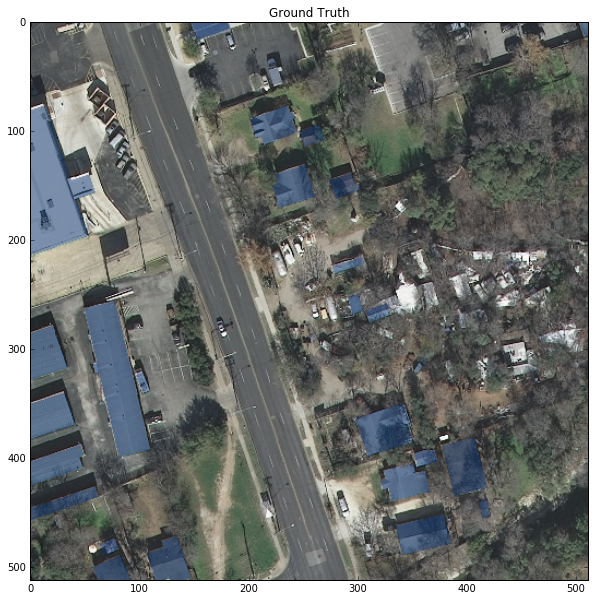

In [6]:
image, label = next(randgen)
label_reshape = np.argmax(label[0], axis=-1).reshape((image.shape[1], image.shape[2]))

plt.figure(figsize=(10, 10))
plt.imshow(image[0])
plt.imshow(label_reshape, cmap=my_cmap, alpha=0.5)
plt.title('Ground Truth')

# Model

In [ ]:
this_run = 'run-01'

logdir = 'logs/'
snapdir = 'snapshots/'
for directory in [logdir, snapdir]:
    rundir = path.join(directory, this_run)
    makedirs(rundir, exist_ok=True)

callbacks = [
    ReduceLROnPlateau('loss', factor=0.2, verbose=1, patience=10, cooldown=5),
    TensorBoard(log_dir=path.join(logdir, this_run)),
    ModelCheckpoint(path.join(snapdir, this_run, 'modelweights.{epoch:02d}-{val_loss:.2f}.hdf5'),
                    save_weights_only=False, verbose=1, period=1),
]


In [ ]:
model = tiramisu(n_classes=2, input_shape=(tile_size[0], tile_size[1], 3))

In [ ]:
model.compile(loss='kld', optimizer=RMSprop(2e-4), metrics=["accuracy"])

# Train

In [ ]:
batch_size = 1
steps_per_image = (5000 // tile_size[0]) * (5000 // tile_size[1]) // 10

model.fit_generator(traingen.random_generator(batch_size),
                    steps_per_epoch=steps_per_image * len(traingen.images),
                    epochs=500, verbose=1, callbacks=callbacks,
                    validation_data=valgen.random_generator(batch_size),
                    validation_steps=steps_per_image * len(valgen.images),
                    max_queue_size=100
                   )

### have a look at output of trained models

In [10]:
model = load_model('/path/to/a/model.hdf5')

In [11]:
gen = valgen.random_generator(1)

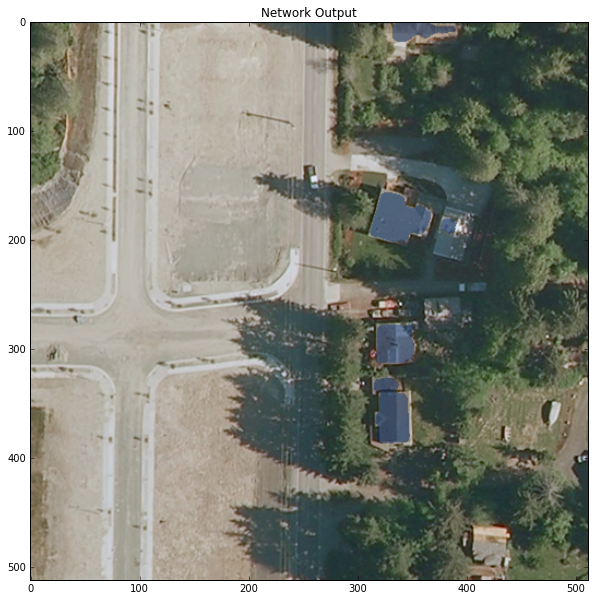

In [12]:
img, label = next(gen)
pred = model.predict(img)

img = img[0]
label = np.argmax(label[0], axis=-1).reshape(*img.shape[:2])
pred = np.argmax(pred[0], axis=-1).reshape(*img.shape[:2])

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.imshow(pred, cmap=my_cmap, alpha=0.5)
plt.title('Network Output')